## Module import 

In [1]:
#LGBM
import lightgbm as lgb

#Tensorflow , keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping, Callback
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.utils import to_categorical ,Sequence, get_custom_objects
#from swa.keras import SWA # swa optimizer - https://pypi.org/project/keras-swa/
from tensorflow.keras.models import load_model

#etc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import json

In [2]:
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('tensorflow : %s'%(tf.__version__))
!python --version

Pandas : 1.0.1
Numpy : 1.18.1
tensorflow : 2.2.0
Python 3.7.6


## Data Call 

In [ ]:
# data_df = pd.read_csv('data/201901-202003.csv')
# display(data_df)

## Data Preprocess 1 

In [ ]:
# col = ['REG_YYMM','CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']
# pre_data_df  = data_df[col]
# group = pre_data_df.groupby([pre_data_df['REG_YYMM'],pre_data_df['CARD_SIDO_NM'],pre_data_df['STD_CLSS_NM']]).sum()
# group.to_csv('data/group_myoung.csv', encoding='utf-8-sig')

## Data Preprocess 2

In [3]:
group_df = pd.read_csv('data/group_myoung.csv')

In [4]:
CARD_SIDO_NM_list = list(group_df['CARD_SIDO_NM'].unique())
STD_CLSS_NM_list =  list(group_df['STD_CLSS_NM'].unique())

for i in range(len(CARD_SIDO_NM_list)):
    tmp_city = CARD_SIDO_NM_list[i]
    group_df['CARD_SIDO_NM'].replace(tmp_city,i,inplace=True)

for i in range(len(STD_CLSS_NM_list)):
    tmp_CLSS = STD_CLSS_NM_list[i]
    group_df['STD_CLSS_NM'].replace(tmp_CLSS,i,inplace=True)

## KERAS 

In [5]:
train_X = group_df[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM']]
train_Y = group_df['AMT']

In [116]:
model = Sequential()
model.add(Dense(128, activation='sigmoid', input_dim=3))
model.add(BatchNormalization())

# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())

# model.add(Dense(80, activation='relu'))
# model.add(BatchNormalization())

# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())

# model.add(Dense(1100, activation='relu'))
# model.add(BatchNormalization())

# model.add(Dense(600, activation='relu'))
# model.add(BatchNormalization())

# model.add(Dense(10, activation='relu'))
# model.add(BatchNormalization())

model.add(Dense(1, activation='linear')) # OUTPUT
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 128)               512       
_________________________________________________________________
batch_normalization_51 (Batc (None, 128)               512       
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 129       
Total params: 1,153
Trainable params: 897
Non-trainable params: 256
_________________________________________________________________


In [117]:
def custom_rmsle(y_true, y_pred):
       return K.sqrt(K.mean(K.square(tf.math.log1p(y_true) - tf.math.log1p(y_pred))))

In [118]:
model.compile(loss=custom_rmsle,
              optimizer='adam'
              #metrics=['accuracy']
             )

In [136]:
model_name = 'MLP_test'
model_path = 'data/history/'+model_name+'.hdf5'

earlystopper = EarlyStopping(
    monitor='val_loss', 
    patience=100, 
    verbose=1,
    mode='min'
)
modelsaver = ModelCheckpoint(
    model_path, 
    monitor='val_loss', 
    verbose=1, 
    #save_best_only=True,
    save_weights_only=True,
    mode='min'
    #period=50
)
lrreducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=.1,
    patience=20,
    verbose=1,
    min_lr=5e-10
)

In [ ]:
epoch_num = 5000
batch_size_num = 6000
validation_split_nm =  0.2
hist = model.fit(train_X, 
                 train_Y, 
                 epochs=epoch_num, 
                 batch_size=batch_size_num, 
                 validation_split=0.2, 
                 callbacks=[earlystopper,modelsaver,lrreducer]
                )

Epoch 1/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2746
Epoch 00001: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 11.2790 - val_loss: 11.1234 - lr: 0.0010
Epoch 2/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.3041
Epoch 00002: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 11.2785 - val_loss: 11.1230 - lr: 0.0010
Epoch 3/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2935
Epoch 00003: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 44ms/step - loss: 11.2782 - val_loss: 11.1226 - lr: 0.0010
Epoch 4/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2587
Epoch 00004: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 44ms/step - loss: 11.2778 - val_loss: 11.1223 - lr: 0.0010
Epoch 5/5000
1/2 [==============>...............] - ETA: 0s - loss: 

1/2 [==============>...............] - ETA: 0s - loss: 11.2472
Epoch 00036: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 41ms/step - loss: 11.2661 - val_loss: 11.1106 - lr: 0.0010
Epoch 37/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2727
Epoch 00037: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 37ms/step - loss: 11.2658 - val_loss: 11.1102 - lr: 0.0010
Epoch 38/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2645
Epoch 00038: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 11.2655 - val_loss: 11.1099 - lr: 0.0010
Epoch 39/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2632
Epoch 00039: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 33ms/step - loss: 11.2651 - val_loss: 11.1095 - lr: 0.0010
Epoch 40/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2643
E

1/2 [==============>...............] - ETA: 0s - loss: 11.2617
Epoch 00071: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 49ms/step - loss: 11.2535 - val_loss: 11.0979 - lr: 0.0010
Epoch 72/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2839
Epoch 00072: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 11.2530 - val_loss: 11.0976 - lr: 0.0010
Epoch 73/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2523
Epoch 00073: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 11.2528 - val_loss: 11.0972 - lr: 0.0010
Epoch 74/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2665
Epoch 00074: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 51ms/step - loss: 11.2524 - val_loss: 11.0969 - lr: 0.0010
Epoch 75/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2318
E

1/2 [==============>...............] - ETA: 0s - loss: 11.2269
Epoch 00106: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 39ms/step - loss: 11.2408 - val_loss: 11.0853 - lr: 0.0010
Epoch 107/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2248
Epoch 00107: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 41ms/step - loss: 11.2404 - val_loss: 11.0850 - lr: 0.0010
Epoch 108/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2489
Epoch 00108: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 39ms/step - loss: 11.2401 - val_loss: 11.0846 - lr: 0.0010
Epoch 109/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2480
Epoch 00109: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 37ms/step - loss: 11.2397 - val_loss: 11.0843 - lr: 0.0010
Epoch 110/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.24

Epoch 141/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2212
Epoch 00141: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 11.2282 - val_loss: 11.0728 - lr: 0.0010
Epoch 142/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2098
Epoch 00142: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 40ms/step - loss: 11.2278 - val_loss: 11.0724 - lr: 0.0010
Epoch 143/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2320
Epoch 00143: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 11.2275 - val_loss: 11.0721 - lr: 0.0010
Epoch 144/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2225
Epoch 00144: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 11.2272 - val_loss: 11.0717 - lr: 0.0010
Epoch 145/5000
1/2 [==============>...............] - ETA: 0

Epoch 176/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2270
Epoch 00176: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 51ms/step - loss: 11.2157 - val_loss: 11.0603 - lr: 0.0010
Epoch 177/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2135
Epoch 00177: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 11.2154 - val_loss: 11.0600 - lr: 0.0010
Epoch 178/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2187
Epoch 00178: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 43ms/step - loss: 11.2150 - val_loss: 11.0596 - lr: 0.0010
Epoch 179/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2278
Epoch 00179: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 42ms/step - loss: 11.2146 - val_loss: 11.0593 - lr: 0.0010
Epoch 180/5000
1/2 [==============>...............] - ETA: 0

Epoch 211/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2170
Epoch 00211: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 11.2033 - val_loss: 11.0480 - lr: 0.0010
Epoch 212/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1914
Epoch 00212: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 33ms/step - loss: 11.2029 - val_loss: 11.0476 - lr: 0.0010
Epoch 213/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2027
Epoch 00213: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 11.2026 - val_loss: 11.0473 - lr: 0.0010
Epoch 214/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.2002
Epoch 00214: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 44ms/step - loss: 11.2022 - val_loss: 11.0469 - lr: 0.0010
Epoch 215/5000
1/2 [==============>...............] - ETA: 0

Epoch 246/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1752
Epoch 00246: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 34ms/step - loss: 11.1909 - val_loss: 11.0356 - lr: 0.0010
Epoch 247/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1868
Epoch 00247: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 39ms/step - loss: 11.1906 - val_loss: 11.0353 - lr: 0.0010
Epoch 248/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1983
Epoch 00248: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 11.1902 - val_loss: 11.0349 - lr: 0.0010
Epoch 249/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1690
Epoch 00249: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 42ms/step - loss: 11.1898 - val_loss: 11.0346 - lr: 0.0010
Epoch 250/5000
1/2 [==============>...............] - ETA: 0

Epoch 281/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1764
Epoch 00281: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 50ms/step - loss: 11.1786 - val_loss: 11.0234 - lr: 0.0010
Epoch 282/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1793
Epoch 00282: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 47ms/step - loss: 11.1783 - val_loss: 11.0230 - lr: 0.0010
Epoch 283/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1630
Epoch 00283: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 35ms/step - loss: 11.1779 - val_loss: 11.0227 - lr: 0.0010
Epoch 284/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1876
Epoch 00284: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 34ms/step - loss: 11.1776 - val_loss: 11.0223 - lr: 0.0010
Epoch 285/5000
1/2 [==============>...............] - ETA: 0

Epoch 316/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1590
Epoch 00316: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 11.1664 - val_loss: 11.0112 - lr: 0.0010
Epoch 317/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1552
Epoch 00317: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 34ms/step - loss: 11.1660 - val_loss: 11.0109 - lr: 0.0010
Epoch 318/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1594
Epoch 00318: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 11.1657 - val_loss: 11.0105 - lr: 0.0010
Epoch 319/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1687
Epoch 00319: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 11.1654 - val_loss: 11.0102 - lr: 0.0010
Epoch 320/5000
1/2 [==============>...............] - ETA: 0

Epoch 351/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1601
Epoch 00351: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 11.1542 - val_loss: 10.9991 - lr: 0.0010
Epoch 352/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1599
Epoch 00352: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 37ms/step - loss: 11.1539 - val_loss: 10.9988 - lr: 0.0010
Epoch 353/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1372
Epoch 00353: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 42ms/step - loss: 11.1535 - val_loss: 10.9984 - lr: 0.0010
Epoch 354/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1279
Epoch 00354: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 43ms/step - loss: 11.1531 - val_loss: 10.9981 - lr: 0.0010
Epoch 355/5000
1/2 [==============>...............] - ETA: 0

Epoch 386/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1344
Epoch 00386: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 11.1421 - val_loss: 10.9871 - lr: 0.0010
Epoch 387/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1473
Epoch 00387: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 11.1418 - val_loss: 10.9867 - lr: 0.0010
Epoch 388/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1485
Epoch 00388: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 11.1415 - val_loss: 10.9864 - lr: 0.0010
Epoch 389/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1209
Epoch 00389: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 11.1411 - val_loss: 10.9860 - lr: 0.0010
Epoch 390/5000
1/2 [==============>...............] - ETA: 0

Epoch 421/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1209
Epoch 00421: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 11.1301 - val_loss: 10.9751 - lr: 0.0010
Epoch 422/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1322
Epoch 00422: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 11.1298 - val_loss: 10.9747 - lr: 0.0010
Epoch 423/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1310
Epoch 00423: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 33ms/step - loss: 11.1294 - val_loss: 10.9744 - lr: 0.0010
Epoch 424/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1577
Epoch 00424: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 11.1290 - val_loss: 10.9741 - lr: 0.0010
Epoch 425/5000
1/2 [==============>...............] - ETA: 0

Epoch 456/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1198
Epoch 00456: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 44ms/step - loss: 11.1182 - val_loss: 10.9632 - lr: 0.0010
Epoch 457/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1426
Epoch 00457: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 11.1177 - val_loss: 10.9628 - lr: 0.0010
Epoch 458/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1025
Epoch 00458: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 34ms/step - loss: 11.1174 - val_loss: 10.9625 - lr: 0.0010
Epoch 459/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1225
Epoch 00459: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 46ms/step - loss: 11.1171 - val_loss: 10.9621 - lr: 0.0010
Epoch 460/5000
1/2 [==============>...............] - ETA: 0

Epoch 491/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1320
Epoch 00491: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 11.1062 - val_loss: 10.9513 - lr: 0.0010
Epoch 492/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0898
Epoch 00492: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 11.1059 - val_loss: 10.9510 - lr: 0.0010
Epoch 493/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0916
Epoch 00493: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 27ms/step - loss: 11.1056 - val_loss: 10.9506 - lr: 0.0010
Epoch 494/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.1101
Epoch 00494: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 11.1052 - val_loss: 10.9503 - lr: 0.0010
Epoch 495/5000
1/2 [==============>...............] - ETA: 0

Epoch 526/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0941
Epoch 00526: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 42ms/step - loss: 11.0944 - val_loss: 10.9395 - lr: 0.0010
Epoch 527/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0773
Epoch 00527: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 37ms/step - loss: 11.0941 - val_loss: 10.9392 - lr: 0.0010
Epoch 528/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0924
Epoch 00528: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 39ms/step - loss: 11.0938 - val_loss: 10.9389 - lr: 0.0010
Epoch 529/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0869
Epoch 00529: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 38ms/step - loss: 11.0934 - val_loss: 10.9385 - lr: 0.0010
Epoch 530/5000
1/2 [==============>...............] - ETA: 0

Epoch 561/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0728
Epoch 00561: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 11.0827 - val_loss: 10.9278 - lr: 0.0010
Epoch 562/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0752
Epoch 00562: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 27ms/step - loss: 11.0823 - val_loss: 10.9275 - lr: 0.0010
Epoch 563/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0733
Epoch 00563: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 11.0820 - val_loss: 10.9271 - lr: 0.0010
Epoch 564/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0674
Epoch 00564: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 11.0816 - val_loss: 10.9268 - lr: 0.0010
Epoch 565/5000
1/2 [==============>...............] - ETA: 0

Epoch 596/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0722
Epoch 00596: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 49ms/step - loss: 11.0710 - val_loss: 10.9162 - lr: 0.0010
Epoch 597/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0798
Epoch 00597: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 72ms/step - loss: 11.0706 - val_loss: 10.9158 - lr: 0.0010
Epoch 598/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0753
Epoch 00598: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 49ms/step - loss: 11.0703 - val_loss: 10.9155 - lr: 0.0010
Epoch 599/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0560
Epoch 00599: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 58ms/step - loss: 11.0699 - val_loss: 10.9152 - lr: 0.0010
Epoch 600/5000
1/2 [==============>...............] - ETA: 0

Epoch 631/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0432
Epoch 00631: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 11.0593 - val_loss: 10.9046 - lr: 0.0010
Epoch 632/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0507
Epoch 00632: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 11.0590 - val_loss: 10.9042 - lr: 0.0010
Epoch 633/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0653
Epoch 00633: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 34ms/step - loss: 11.0587 - val_loss: 10.9039 - lr: 0.0010
Epoch 634/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0736
Epoch 00634: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 42ms/step - loss: 11.0583 - val_loss: 10.9036 - lr: 0.0010
Epoch 635/5000
1/2 [==============>...............] - ETA: 0

Epoch 666/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0481
Epoch 00666: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 34ms/step - loss: 11.0477 - val_loss: 10.8930 - lr: 0.0010
Epoch 667/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0704
Epoch 00667: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 34ms/step - loss: 11.0473 - val_loss: 10.8927 - lr: 0.0010
Epoch 668/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0549
Epoch 00668: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 11.0471 - val_loss: 10.8924 - lr: 0.0010
Epoch 669/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0206
Epoch 00669: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 11.0466 - val_loss: 10.8920 - lr: 0.0010
Epoch 670/5000
1/2 [==============>...............] - ETA: 0

Epoch 701/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0271
Epoch 00701: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 44ms/step - loss: 11.0362 - val_loss: 10.8816 - lr: 0.0010
Epoch 702/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0093
Epoch 00702: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 36ms/step - loss: 11.0358 - val_loss: 10.8812 - lr: 0.0010
Epoch 703/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0292
Epoch 00703: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 38ms/step - loss: 11.0356 - val_loss: 10.8809 - lr: 0.0010
Epoch 704/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0406
Epoch 00704: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 11.0352 - val_loss: 10.8806 - lr: 0.0010
Epoch 705/5000
1/2 [==============>...............] - ETA: 0

Epoch 736/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0261
Epoch 00736: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 42ms/step - loss: 11.0248 - val_loss: 10.8702 - lr: 0.0010
Epoch 737/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9985
Epoch 00737: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 11.0243 - val_loss: 10.8698 - lr: 0.0010
Epoch 738/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0413
Epoch 00738: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 38ms/step - loss: 11.0241 - val_loss: 10.8695 - lr: 0.0010
Epoch 739/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0336
Epoch 00739: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 39ms/step - loss: 11.0238 - val_loss: 10.8692 - lr: 0.0010
Epoch 740/5000
1/2 [==============>...............] - ETA: 0

Epoch 771/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0208
Epoch 00771: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 34ms/step - loss: 11.0134 - val_loss: 10.8588 - lr: 0.0010
Epoch 772/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9996
Epoch 00772: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 37ms/step - loss: 11.0130 - val_loss: 10.8585 - lr: 0.0010
Epoch 773/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0363
Epoch 00773: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 37ms/step - loss: 11.0126 - val_loss: 10.8582 - lr: 0.0010
Epoch 774/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0051
Epoch 00774: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 74ms/step - loss: 11.0124 - val_loss: 10.8578 - lr: 0.0010
Epoch 775/5000
1/2 [==============>...............] - ETA: 0

Epoch 806/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0079
Epoch 00806: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 37ms/step - loss: 11.0020 - val_loss: 10.8475 - lr: 0.0010
Epoch 807/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9864
Epoch 00807: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 33ms/step - loss: 11.0017 - val_loss: 10.8472 - lr: 0.0010
Epoch 808/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0241
Epoch 00808: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 35ms/step - loss: 11.0013 - val_loss: 10.8469 - lr: 0.0010
Epoch 809/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0093
Epoch 00809: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 11.0011 - val_loss: 10.8466 - lr: 0.0010
Epoch 810/5000
1/2 [==============>...............] - ETA: 0

Epoch 841/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9948
Epoch 00841: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.9908 - val_loss: 10.8363 - lr: 0.0010
Epoch 842/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0004
Epoch 00842: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 10.9904 - val_loss: 10.8360 - lr: 0.0010
Epoch 843/5000
1/2 [==============>...............] - ETA: 0s - loss: 11.0153
Epoch 00843: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 36ms/step - loss: 10.9900 - val_loss: 10.8357 - lr: 0.0010
Epoch 844/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9878
Epoch 00844: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.9898 - val_loss: 10.8353 - lr: 0.0010
Epoch 845/5000
1/2 [==============>...............] - ETA: 0

Epoch 876/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9698
Epoch 00876: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.9795 - val_loss: 10.8251 - lr: 0.0010
Epoch 877/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9706
Epoch 00877: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.9792 - val_loss: 10.8248 - lr: 0.0010
Epoch 878/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9648
Epoch 00878: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.9789 - val_loss: 10.8245 - lr: 0.0010
Epoch 879/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9773
Epoch 00879: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.9786 - val_loss: 10.8242 - lr: 0.0010
Epoch 880/5000
1/2 [==============>...............] - ETA: 0

Epoch 911/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9684
Epoch 00911: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.9684 - val_loss: 10.8140 - lr: 0.0010
Epoch 912/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9534
Epoch 00912: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 35ms/step - loss: 10.9680 - val_loss: 10.8137 - lr: 0.0010
Epoch 913/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9701
Epoch 00913: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.9678 - val_loss: 10.8134 - lr: 0.0010
Epoch 914/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9647
Epoch 00914: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 35ms/step - loss: 10.9674 - val_loss: 10.8131 - lr: 0.0010
Epoch 915/5000
1/2 [==============>...............] - ETA: 0

Epoch 946/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9405
Epoch 00946: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 43ms/step - loss: 10.9572 - val_loss: 10.8030 - lr: 0.0010
Epoch 947/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9484
Epoch 00947: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 60ms/step - loss: 10.9570 - val_loss: 10.8026 - lr: 0.0010
Epoch 948/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9747
Epoch 00948: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 47ms/step - loss: 10.9566 - val_loss: 10.8023 - lr: 0.0010
Epoch 949/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9492
Epoch 00949: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 40ms/step - loss: 10.9563 - val_loss: 10.8020 - lr: 0.0010
Epoch 950/5000
1/2 [==============>...............] - ETA: 0

Epoch 981/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9443
Epoch 00981: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.9463 - val_loss: 10.7920 - lr: 0.0010
Epoch 982/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9471
Epoch 00982: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.9459 - val_loss: 10.7916 - lr: 0.0010
Epoch 983/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9520
Epoch 00983: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.9456 - val_loss: 10.7913 - lr: 0.0010
Epoch 984/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9450
Epoch 00984: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.9453 - val_loss: 10.7910 - lr: 0.0010
Epoch 985/5000
1/2 [==============>...............] - ETA: 0

Epoch 1016/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9290
Epoch 01016: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 45ms/step - loss: 10.9353 - val_loss: 10.7810 - lr: 0.0010
Epoch 1017/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9379
Epoch 01017: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.9350 - val_loss: 10.7807 - lr: 0.0010
Epoch 1018/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9363
Epoch 01018: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.9346 - val_loss: 10.7804 - lr: 0.0010
Epoch 1019/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9570
Epoch 01019: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 40ms/step - loss: 10.9342 - val_loss: 10.7801 - lr: 0.0010
Epoch 1020/5000
1/2 [==============>...............] - E

Epoch 1051/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9151
Epoch 01051: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.9243 - val_loss: 10.7701 - lr: 0.0010
Epoch 1052/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9218
Epoch 01052: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 38ms/step - loss: 10.9240 - val_loss: 10.7698 - lr: 0.0010
Epoch 1053/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9328
Epoch 01053: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 46ms/step - loss: 10.9237 - val_loss: 10.7695 - lr: 0.0010
Epoch 1054/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9015
Epoch 01054: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 45ms/step - loss: 10.9233 - val_loss: 10.7692 - lr: 0.0010
Epoch 1055/5000
1/2 [==============>...............] - E

Epoch 1086/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9126
Epoch 01086: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 41ms/step - loss: 10.9135 - val_loss: 10.7593 - lr: 0.0010
Epoch 1087/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9171
Epoch 01087: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.9132 - val_loss: 10.7590 - lr: 0.0010
Epoch 1088/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9017
Epoch 01088: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 43ms/step - loss: 10.9128 - val_loss: 10.7587 - lr: 0.0010
Epoch 1089/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9069
Epoch 01089: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 43ms/step - loss: 10.9125 - val_loss: 10.7584 - lr: 0.0010
Epoch 1090/5000
1/2 [==============>...............] - E

Epoch 1121/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8964
Epoch 01121: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.9026 - val_loss: 10.7485 - lr: 0.0010
Epoch 1122/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8951
Epoch 01122: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 10.9023 - val_loss: 10.7482 - lr: 0.0010
Epoch 1123/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9058
Epoch 01123: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 37ms/step - loss: 10.9020 - val_loss: 10.7479 - lr: 0.0010
Epoch 1124/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9205
Epoch 01124: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.9017 - val_loss: 10.7476 - lr: 0.0010
Epoch 1125/5000
1/2 [==============>...............] - E

Epoch 1156/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8824
Epoch 01156: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 42ms/step - loss: 10.8919 - val_loss: 10.7378 - lr: 0.0010
Epoch 1157/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8978
Epoch 01157: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 44ms/step - loss: 10.8916 - val_loss: 10.7375 - lr: 0.0010
Epoch 1158/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8912
Epoch 01158: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 41ms/step - loss: 10.8913 - val_loss: 10.7372 - lr: 0.0010
Epoch 1159/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8779
Epoch 01159: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.8909 - val_loss: 10.7369 - lr: 0.0010
Epoch 1160/5000
1/2 [==============>...............] - E

Epoch 1191/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8598
Epoch 01191: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.8811 - val_loss: 10.7272 - lr: 0.0010
Epoch 1192/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.9188
Epoch 01192: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 42ms/step - loss: 10.8806 - val_loss: 10.7268 - lr: 0.0010
Epoch 1193/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8671
Epoch 01193: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 42ms/step - loss: 10.8805 - val_loss: 10.7265 - lr: 0.0010
Epoch 1194/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8757
Epoch 01194: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 43ms/step - loss: 10.8803 - val_loss: 10.7262 - lr: 0.0010
Epoch 1195/5000
1/2 [==============>...............] - E

Epoch 1226/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8638
Epoch 01226: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 40ms/step - loss: 10.8705 - val_loss: 10.7165 - lr: 0.0010
Epoch 1227/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8640
Epoch 01227: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.8702 - val_loss: 10.7162 - lr: 0.0010
Epoch 1228/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8903
Epoch 01228: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 51ms/step - loss: 10.8698 - val_loss: 10.7159 - lr: 0.0010
Epoch 1229/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8559
Epoch 01229: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 37ms/step - loss: 10.8696 - val_loss: 10.7156 - lr: 0.0010
Epoch 1230/5000
1/2 [==============>...............] - E

Epoch 1261/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8558
Epoch 01261: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 34ms/step - loss: 10.8599 - val_loss: 10.7060 - lr: 0.0010
Epoch 1262/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8712
Epoch 01262: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.8596 - val_loss: 10.7057 - lr: 0.0010
Epoch 1263/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8529
Epoch 01263: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 10.8593 - val_loss: 10.7054 - lr: 0.0010
Epoch 1264/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8661
Epoch 01264: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.8590 - val_loss: 10.7051 - lr: 0.0010
Epoch 1265/5000
1/2 [==============>...............] - E

Epoch 1296/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8289
Epoch 01296: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 44ms/step - loss: 10.8493 - val_loss: 10.6955 - lr: 0.0010
Epoch 1297/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8573
Epoch 01297: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 33ms/step - loss: 10.8490 - val_loss: 10.6952 - lr: 0.0010
Epoch 1298/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8485
Epoch 01298: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 47ms/step - loss: 10.8488 - val_loss: 10.6949 - lr: 0.0010
Epoch 1299/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8701
Epoch 01299: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 43ms/step - loss: 10.8484 - val_loss: 10.6946 - lr: 0.0010
Epoch 1300/5000
1/2 [==============>...............] - E

Epoch 1331/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8553
Epoch 01331: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.8388 - val_loss: 10.6850 - lr: 0.0010
Epoch 1332/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8448
Epoch 01332: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.8386 - val_loss: 10.6847 - lr: 0.0010
Epoch 1333/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8311
Epoch 01333: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 36ms/step - loss: 10.8383 - val_loss: 10.6844 - lr: 0.0010
Epoch 1334/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8410
Epoch 01334: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.8380 - val_loss: 10.6841 - lr: 0.0010
Epoch 1335/5000
1/2 [==============>...............] - E

Epoch 1366/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8439
Epoch 01366: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.8284 - val_loss: 10.6746 - lr: 0.0010
Epoch 1367/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8138
Epoch 01367: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.8281 - val_loss: 10.6743 - lr: 0.0010
Epoch 1368/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8623
Epoch 01368: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 35ms/step - loss: 10.8276 - val_loss: 10.6740 - lr: 0.0010
Epoch 1369/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8367
Epoch 01369: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 35ms/step - loss: 10.8275 - val_loss: 10.6737 - lr: 0.0010
Epoch 1370/5000
1/2 [==============>...............] - E

Epoch 1401/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8172
Epoch 01401: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 10.8180 - val_loss: 10.6643 - lr: 0.0010
Epoch 1402/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8380
Epoch 01402: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 34ms/step - loss: 10.8177 - val_loss: 10.6640 - lr: 0.0010
Epoch 1403/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8120
Epoch 01403: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 10.8174 - val_loss: 10.6637 - lr: 0.0010
Epoch 1404/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7828
Epoch 01404: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.8169 - val_loss: 10.6634 - lr: 0.0010
Epoch 1405/5000
1/2 [==============>...............] - E

Epoch 1436/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8011
Epoch 01436: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.8077 - val_loss: 10.6540 - lr: 0.0010
Epoch 1437/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8018
Epoch 01437: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 10.8074 - val_loss: 10.6537 - lr: 0.0010
Epoch 1438/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8154
Epoch 01438: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.8071 - val_loss: 10.6534 - lr: 0.0010
Epoch 1439/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7993
Epoch 01439: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.8068 - val_loss: 10.6531 - lr: 0.0010
Epoch 1440/5000
1/2 [==============>...............] - E

Epoch 1471/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7865
Epoch 01471: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.7974 - val_loss: 10.6437 - lr: 0.0010
Epoch 1472/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7998
Epoch 01472: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 40ms/step - loss: 10.7971 - val_loss: 10.6434 - lr: 0.0010
Epoch 1473/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7901
Epoch 01473: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 43ms/step - loss: 10.7968 - val_loss: 10.6431 - lr: 0.0010
Epoch 1474/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8036
Epoch 01474: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 38ms/step - loss: 10.7965 - val_loss: 10.6428 - lr: 0.0010
Epoch 1475/5000
1/2 [==============>...............] - E

Epoch 1506/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7766
Epoch 01506: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.7871 - val_loss: 10.6335 - lr: 0.0010
Epoch 1507/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7907
Epoch 01507: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.7868 - val_loss: 10.6332 - lr: 0.0010
Epoch 1508/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7855
Epoch 01508: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.7866 - val_loss: 10.6329 - lr: 0.0010
Epoch 1509/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.8197
Epoch 01509: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.7861 - val_loss: 10.6326 - lr: 0.0010
Epoch 1510/5000
1/2 [==============>...............] - E

Epoch 1541/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7551
Epoch 01541: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 35ms/step - loss: 10.7769 - val_loss: 10.6234 - lr: 0.0010
Epoch 1542/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7713
Epoch 01542: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 42ms/step - loss: 10.7767 - val_loss: 10.6231 - lr: 0.0010
Epoch 1543/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7860
Epoch 01543: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.7763 - val_loss: 10.6228 - lr: 0.0010
Epoch 1544/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7714
Epoch 01544: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.7761 - val_loss: 10.6225 - lr: 0.0010
Epoch 1545/5000
1/2 [==============>...............] - E

Epoch 1576/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7943
Epoch 01576: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 40ms/step - loss: 10.7667 - val_loss: 10.6133 - lr: 0.0010
Epoch 1577/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7810
Epoch 01577: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 10.7665 - val_loss: 10.6130 - lr: 0.0010
Epoch 1578/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7670
Epoch 01578: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 43ms/step - loss: 10.7662 - val_loss: 10.6127 - lr: 0.0010
Epoch 1579/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7812
Epoch 01579: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.7659 - val_loss: 10.6124 - lr: 0.0010
Epoch 1580/5000
1/2 [==============>...............] - E

Epoch 1611/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7438
Epoch 01611: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.7567 - val_loss: 10.6032 - lr: 0.0010
Epoch 1612/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7320
Epoch 01612: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.7563 - val_loss: 10.6029 - lr: 0.0010
Epoch 1613/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7347
Epoch 01613: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 33ms/step - loss: 10.7560 - val_loss: 10.6026 - lr: 0.0010
Epoch 1614/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7511
Epoch 01614: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 36ms/step - loss: 10.7558 - val_loss: 10.6024 - lr: 0.0010
Epoch 1615/5000
1/2 [==============>...............] - E

Epoch 1646/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7631
Epoch 01646: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.7466 - val_loss: 10.5932 - lr: 0.0010
Epoch 1647/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7448
Epoch 01647: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.7464 - val_loss: 10.5929 - lr: 0.0010
Epoch 1648/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7624
Epoch 01648: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.7460 - val_loss: 10.5926 - lr: 0.0010
Epoch 1649/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7660
Epoch 01649: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 36ms/step - loss: 10.7457 - val_loss: 10.5924 - lr: 0.0010
Epoch 1650/5000
1/2 [==============>...............] - E

Epoch 1681/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7488
Epoch 01681: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 56ms/step - loss: 10.7366 - val_loss: 10.5833 - lr: 0.0010
Epoch 1682/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7219
Epoch 01682: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.7363 - val_loss: 10.5830 - lr: 0.0010
Epoch 1683/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7752
Epoch 01683: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 35ms/step - loss: 10.7358 - val_loss: 10.5827 - lr: 0.0010
Epoch 1684/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7369
Epoch 01684: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.7358 - val_loss: 10.5824 - lr: 0.0010
Epoch 1685/5000
1/2 [==============>...............] - E

Epoch 1716/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7104
Epoch 01716: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 36ms/step - loss: 10.7267 - val_loss: 10.5733 - lr: 0.0010
Epoch 1717/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7041
Epoch 01717: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 39ms/step - loss: 10.7263 - val_loss: 10.5731 - lr: 0.0010
Epoch 1718/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7329
Epoch 01718: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 38ms/step - loss: 10.7261 - val_loss: 10.5728 - lr: 0.0010
Epoch 1719/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7125
Epoch 01719: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 54ms/step - loss: 10.7258 - val_loss: 10.5725 - lr: 0.0010
Epoch 1720/5000
1/2 [==============>...............] - E

Epoch 1751/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6982
Epoch 01751: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 38ms/step - loss: 10.7167 - val_loss: 10.5635 - lr: 0.0010
Epoch 1752/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7024
Epoch 01752: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.7165 - val_loss: 10.5632 - lr: 0.0010
Epoch 1753/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7217
Epoch 01753: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.7162 - val_loss: 10.5629 - lr: 0.0010
Epoch 1754/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7198
Epoch 01754: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 52ms/step - loss: 10.7159 - val_loss: 10.5626 - lr: 0.0010
Epoch 1755/5000
1/2 [==============>...............] - E

Epoch 1786/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7041
Epoch 01786: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 27ms/step - loss: 10.7069 - val_loss: 10.5537 - lr: 0.0010
Epoch 1787/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7232
Epoch 01787: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 34ms/step - loss: 10.7066 - val_loss: 10.5534 - lr: 0.0010
Epoch 1788/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6835
Epoch 01788: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.7063 - val_loss: 10.5531 - lr: 0.0010
Epoch 1789/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7336
Epoch 01789: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.7060 - val_loss: 10.5528 - lr: 0.0010
Epoch 1790/5000
1/2 [==============>...............] - E

Epoch 1821/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7114
Epoch 01821: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 38ms/step - loss: 10.6971 - val_loss: 10.5439 - lr: 0.0010
Epoch 1822/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7220
Epoch 01822: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.6967 - val_loss: 10.5436 - lr: 0.0010
Epoch 1823/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6951
Epoch 01823: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 33ms/step - loss: 10.6966 - val_loss: 10.5433 - lr: 0.0010
Epoch 1824/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7100
Epoch 01824: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.6963 - val_loss: 10.5431 - lr: 0.0010
Epoch 1825/5000
1/2 [==============>...............] - E

Epoch 1856/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7160
Epoch 01856: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 10.6872 - val_loss: 10.5342 - lr: 0.0010
Epoch 1857/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7060
Epoch 01857: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 43ms/step - loss: 10.6870 - val_loss: 10.5339 - lr: 0.0010
Epoch 1858/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6877
Epoch 01858: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.6868 - val_loss: 10.5336 - lr: 0.0010
Epoch 1859/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6994
Epoch 01859: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 38ms/step - loss: 10.6865 - val_loss: 10.5333 - lr: 0.0010
Epoch 1860/5000
1/2 [==============>...............] - E

Epoch 1891/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.7006
Epoch 01891: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.6775 - val_loss: 10.5245 - lr: 0.0010
Epoch 1892/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6578
Epoch 01892: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 41ms/step - loss: 10.6773 - val_loss: 10.5242 - lr: 0.0010
Epoch 1893/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6830
Epoch 01893: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 44ms/step - loss: 10.6771 - val_loss: 10.5239 - lr: 0.0010
Epoch 1894/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6675
Epoch 01894: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 27ms/step - loss: 10.6768 - val_loss: 10.5237 - lr: 0.0010
Epoch 1895/5000
1/2 [==============>...............] - E

Epoch 1926/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6566
Epoch 01926: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.6679 - val_loss: 10.5149 - lr: 0.0010
Epoch 1927/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6658
Epoch 01927: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 54ms/step - loss: 10.6677 - val_loss: 10.5146 - lr: 0.0010
Epoch 1928/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6651
Epoch 01928: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 37ms/step - loss: 10.6674 - val_loss: 10.5143 - lr: 0.0010
Epoch 1929/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6650
Epoch 01929: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 50ms/step - loss: 10.6671 - val_loss: 10.5140 - lr: 0.0010
Epoch 1930/5000
1/2 [==============>...............] - E

Epoch 1961/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6648
Epoch 01961: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 35ms/step - loss: 10.6583 - val_loss: 10.5053 - lr: 0.0010
Epoch 1962/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6577
Epoch 01962: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 10.6581 - val_loss: 10.5050 - lr: 0.0010
Epoch 1963/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6335
Epoch 01963: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 42ms/step - loss: 10.6577 - val_loss: 10.5047 - lr: 0.0010
Epoch 1964/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6480
Epoch 01964: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.6575 - val_loss: 10.5045 - lr: 0.0010
Epoch 1965/5000
1/2 [==============>...............] - E

Epoch 1996/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6694
Epoch 01996: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 71ms/step - loss: 10.6487 - val_loss: 10.4957 - lr: 0.0010
Epoch 1997/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6464
Epoch 01997: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.6485 - val_loss: 10.4955 - lr: 0.0010
Epoch 1998/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6485
Epoch 01998: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 27ms/step - loss: 10.6482 - val_loss: 10.4952 - lr: 0.0010
Epoch 1999/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6827
Epoch 01999: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.6477 - val_loss: 10.4949 - lr: 0.0010
Epoch 2000/5000
1/2 [==============>...............] - E

Epoch 2031/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6308
Epoch 02031: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 41ms/step - loss: 10.6392 - val_loss: 10.4862 - lr: 0.0010
Epoch 2032/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6518
Epoch 02032: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.6389 - val_loss: 10.4860 - lr: 0.0010
Epoch 2033/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6258
Epoch 02033: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 35ms/step - loss: 10.6386 - val_loss: 10.4857 - lr: 0.0010
Epoch 2034/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6340
Epoch 02034: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.6384 - val_loss: 10.4854 - lr: 0.0010
Epoch 2035/5000
1/2 [==============>...............] - E

Epoch 2066/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6379
Epoch 02066: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 44ms/step - loss: 10.6297 - val_loss: 10.4768 - lr: 0.0010
Epoch 2067/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6226
Epoch 02067: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.6294 - val_loss: 10.4765 - lr: 0.0010
Epoch 2068/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6308
Epoch 02068: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 33ms/step - loss: 10.6292 - val_loss: 10.4762 - lr: 0.0010
Epoch 2069/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6279
Epoch 02069: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.6289 - val_loss: 10.4760 - lr: 0.0010
Epoch 2070/5000
1/2 [==============>...............] - E

Epoch 2101/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6199
Epoch 02101: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 48ms/step - loss: 10.6202 - val_loss: 10.4674 - lr: 0.0010
Epoch 2102/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6194
Epoch 02102: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 34ms/step - loss: 10.6200 - val_loss: 10.4671 - lr: 0.0010
Epoch 2103/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6463
Epoch 02103: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.6196 - val_loss: 10.4668 - lr: 0.0010
Epoch 2104/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5908
Epoch 02104: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 10.6193 - val_loss: 10.4666 - lr: 0.0010
Epoch 2105/5000
1/2 [==============>...............] - E

Epoch 2136/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5955
Epoch 02136: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 10.6108 - val_loss: 10.4580 - lr: 0.0010
Epoch 2137/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6119
Epoch 02137: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.6106 - val_loss: 10.4577 - lr: 0.0010
Epoch 2138/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6119
Epoch 02138: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 33ms/step - loss: 10.6103 - val_loss: 10.4575 - lr: 0.0010
Epoch 2139/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5883
Epoch 02139: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.6099 - val_loss: 10.4572 - lr: 0.0010
Epoch 2140/5000
1/2 [==============>...............] - E

Epoch 2171/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5835
Epoch 02171: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.6014 - val_loss: 10.4487 - lr: 0.0010
Epoch 2172/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5887
Epoch 02172: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.6012 - val_loss: 10.4484 - lr: 0.0010
Epoch 2173/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6128
Epoch 02173: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 33ms/step - loss: 10.6009 - val_loss: 10.4481 - lr: 0.0010
Epoch 2174/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5929
Epoch 02174: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 50ms/step - loss: 10.6006 - val_loss: 10.4479 - lr: 0.0010
Epoch 2175/5000
1/2 [==============>...............] - E

Epoch 2206/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5607
Epoch 02206: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.5919 - val_loss: 10.4394 - lr: 0.0010
Epoch 2207/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5794
Epoch 02207: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 243ms/step - loss: 10.5918 - val_loss: 10.4391 - lr: 0.0010
Epoch 2208/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.6015
Epoch 02208: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 10.5916 - val_loss: 10.4388 - lr: 0.0010
Epoch 2209/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5918
Epoch 02209: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.5913 - val_loss: 10.4386 - lr: 0.0010
Epoch 2210/5000
1/2 [==============>...............] - 

Epoch 2241/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5788
Epoch 02241: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 33ms/step - loss: 10.5828 - val_loss: 10.4301 - lr: 0.0010
Epoch 2242/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5736
Epoch 02242: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 46ms/step - loss: 10.5826 - val_loss: 10.4299 - lr: 0.0010
Epoch 2243/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5859
Epoch 02243: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 10.5823 - val_loss: 10.4296 - lr: 0.0010
Epoch 2244/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5702
Epoch 02244: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.5820 - val_loss: 10.4293 - lr: 0.0010
Epoch 2245/5000
1/2 [==============>...............] - E

Epoch 2276/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5780
Epoch 02276: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 33ms/step - loss: 10.5736 - val_loss: 10.4209 - lr: 0.0010
Epoch 2277/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5503
Epoch 02277: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.5732 - val_loss: 10.4207 - lr: 0.0010
Epoch 2278/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5862
Epoch 02278: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.5730 - val_loss: 10.4204 - lr: 0.0010
Epoch 2279/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5805
Epoch 02279: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 39ms/step - loss: 10.5728 - val_loss: 10.4201 - lr: 0.0010
Epoch 2280/5000
1/2 [==============>...............] - E

Epoch 2311/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5700
Epoch 02311: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 39ms/step - loss: 10.5644 - val_loss: 10.4118 - lr: 0.0010
Epoch 2312/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5592
Epoch 02312: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 34ms/step - loss: 10.5641 - val_loss: 10.4115 - lr: 0.0010
Epoch 2313/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5588
Epoch 02313: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 38ms/step - loss: 10.5639 - val_loss: 10.4112 - lr: 0.0010
Epoch 2314/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5357
Epoch 02314: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.5635 - val_loss: 10.4110 - lr: 0.0010
Epoch 2315/5000
1/2 [==============>...............] - E

Epoch 2346/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5475
Epoch 02346: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.5552 - val_loss: 10.4026 - lr: 0.0010
Epoch 2347/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5595
Epoch 02347: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 55ms/step - loss: 10.5550 - val_loss: 10.4024 - lr: 0.0010
Epoch 2348/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5689
Epoch 02348: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.5547 - val_loss: 10.4021 - lr: 0.0010
Epoch 2349/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5395
Epoch 02349: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 42ms/step - loss: 10.5544 - val_loss: 10.4018 - lr: 0.0010
Epoch 2350/5000
1/2 [==============>...............] - E

Epoch 2381/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5488
Epoch 02381: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 43ms/step - loss: 10.5461 - val_loss: 10.3935 - lr: 0.0010
Epoch 2382/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5459
Epoch 02382: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 59ms/step - loss: 10.5458 - val_loss: 10.3933 - lr: 0.0010
Epoch 2383/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5728
Epoch 02383: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.5454 - val_loss: 10.3930 - lr: 0.0010
Epoch 2384/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5322
Epoch 02384: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 46ms/step - loss: 10.5453 - val_loss: 10.3928 - lr: 0.0010
Epoch 2385/5000
1/2 [==============>...............] - E

Epoch 2416/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5361
Epoch 02416: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.5370 - val_loss: 10.3845 - lr: 0.0010
Epoch 2417/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5210
Epoch 02417: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 10.5367 - val_loss: 10.3843 - lr: 0.0010
Epoch 2418/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5251
Epoch 02418: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.5365 - val_loss: 10.3840 - lr: 0.0010
Epoch 2419/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5317
Epoch 02419: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.5362 - val_loss: 10.3837 - lr: 0.0010
Epoch 2420/5000
1/2 [==============>...............] - E

Epoch 2451/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5266
Epoch 02451: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 34ms/step - loss: 10.5280 - val_loss: 10.3755 - lr: 0.0010
Epoch 2452/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4991
Epoch 02452: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.5276 - val_loss: 10.3753 - lr: 0.0010
Epoch 2453/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5379
Epoch 02453: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 56ms/step - loss: 10.5274 - val_loss: 10.3750 - lr: 0.0010
Epoch 2454/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5334
Epoch 02454: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.5272 - val_loss: 10.3747 - lr: 0.0010
Epoch 2455/5000
1/2 [==============>...............] - E

Epoch 2486/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5128
Epoch 02486: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 45ms/step - loss: 10.5190 - val_loss: 10.3665 - lr: 0.0010
Epoch 2487/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5167
Epoch 02487: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 41ms/step - loss: 10.5187 - val_loss: 10.3663 - lr: 0.0010
Epoch 2488/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5226
Epoch 02488: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 44ms/step - loss: 10.5185 - val_loss: 10.3660 - lr: 0.0010
Epoch 2489/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5203
Epoch 02489: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.5182 - val_loss: 10.3658 - lr: 0.0010
Epoch 2490/5000
1/2 [==============>...............] - E

Epoch 2521/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4737
Epoch 02521: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 42ms/step - loss: 10.5098 - val_loss: 10.3576 - lr: 0.0010
Epoch 2522/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4868
Epoch 02522: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 39ms/step - loss: 10.5097 - val_loss: 10.3574 - lr: 0.0010
Epoch 2523/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5067
Epoch 02523: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.5095 - val_loss: 10.3571 - lr: 0.0010
Epoch 2524/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4997
Epoch 02524: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 69ms/step - loss: 10.5092 - val_loss: 10.3569 - lr: 0.0010
Epoch 2525/5000
1/2 [==============>...............] - E

Epoch 2556/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4760
Epoch 02556: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 39ms/step - loss: 10.5010 - val_loss: 10.3487 - lr: 0.0010
Epoch 2557/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5000
Epoch 02557: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 33ms/step - loss: 10.5008 - val_loss: 10.3485 - lr: 0.0010
Epoch 2558/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4769
Epoch 02558: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.5005 - val_loss: 10.3482 - lr: 0.0010
Epoch 2559/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5021
Epoch 02559: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 38ms/step - loss: 10.5003 - val_loss: 10.3480 - lr: 0.0010
Epoch 2560/5000
1/2 [==============>...............] - E

Epoch 2591/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4770
Epoch 02591: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.4921 - val_loss: 10.3399 - lr: 0.0010
Epoch 2592/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5173
Epoch 02592: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.4918 - val_loss: 10.3396 - lr: 0.0010
Epoch 2593/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4726
Epoch 02593: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.4916 - val_loss: 10.3394 - lr: 0.0010
Epoch 2594/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.5075
Epoch 02594: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 34ms/step - loss: 10.4914 - val_loss: 10.3391 - lr: 0.0010
Epoch 2595/5000
1/2 [==============>...............] - E

Epoch 2626/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4731
Epoch 02626: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.4833 - val_loss: 10.3311 - lr: 0.0010
Epoch 2627/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4561
Epoch 02627: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.4829 - val_loss: 10.3308 - lr: 0.0010
Epoch 2628/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4950
Epoch 02628: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 27ms/step - loss: 10.4828 - val_loss: 10.3306 - lr: 0.0010
Epoch 2629/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4812
Epoch 02629: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.4826 - val_loss: 10.3303 - lr: 0.0010
Epoch 2630/5000
1/2 [==============>...............] - E

Epoch 2661/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4765
Epoch 02661: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.4745 - val_loss: 10.3223 - lr: 0.0010
Epoch 2662/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4658
Epoch 02662: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 179ms/step - loss: 10.4743 - val_loss: 10.3221 - lr: 0.0010
Epoch 2663/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4861
Epoch 02663: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.4740 - val_loss: 10.3218 - lr: 0.0010
Epoch 2664/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4774
Epoch 02664: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.4738 - val_loss: 10.3216 - lr: 0.0010
Epoch 2665/5000
1/2 [==============>...............] - 

Epoch 2696/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4526
Epoch 02696: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.4657 - val_loss: 10.3136 - lr: 0.0010
Epoch 2697/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4528
Epoch 02697: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 35ms/step - loss: 10.4655 - val_loss: 10.3133 - lr: 0.0010
Epoch 2698/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4645
Epoch 02698: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 39ms/step - loss: 10.4652 - val_loss: 10.3131 - lr: 0.0010
Epoch 2699/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4638
Epoch 02699: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 40ms/step - loss: 10.4650 - val_loss: 10.3128 - lr: 0.0010
Epoch 2700/5000
1/2 [==============>...............] - E

Epoch 2731/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4603
Epoch 02731: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 38ms/step - loss: 10.4570 - val_loss: 10.3049 - lr: 0.0010
Epoch 2732/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4553
Epoch 02732: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 40ms/step - loss: 10.4568 - val_loss: 10.3046 - lr: 0.0010
Epoch 2733/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4359
Epoch 02733: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 10.4564 - val_loss: 10.3044 - lr: 0.0010
Epoch 2734/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4686
Epoch 02734: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 35ms/step - loss: 10.4562 - val_loss: 10.3041 - lr: 0.0010
Epoch 2735/5000
1/2 [==============>...............] - E

Epoch 2766/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4566
Epoch 02766: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 39ms/step - loss: 10.4483 - val_loss: 10.2962 - lr: 0.0010
Epoch 2767/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4507
Epoch 02767: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 34ms/step - loss: 10.4481 - val_loss: 10.2960 - lr: 0.0010
Epoch 2768/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4626
Epoch 02768: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 48ms/step - loss: 10.4478 - val_loss: 10.2957 - lr: 0.0010
Epoch 2769/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4597
Epoch 02769: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 45ms/step - loss: 10.4475 - val_loss: 10.2955 - lr: 0.0010
Epoch 2770/5000
1/2 [==============>...............] - E

Epoch 2801/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4750
Epoch 02801: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 40ms/step - loss: 10.4394 - val_loss: 10.2876 - lr: 0.0010
Epoch 2802/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4558
Epoch 02802: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.4394 - val_loss: 10.2873 - lr: 0.0010
Epoch 2803/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4268
Epoch 02803: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 50ms/step - loss: 10.4391 - val_loss: 10.2871 - lr: 0.0010
Epoch 2804/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4481
Epoch 02804: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 34ms/step - loss: 10.4389 - val_loss: 10.2869 - lr: 0.0010
Epoch 2805/5000
1/2 [==============>...............] - E

Epoch 2836/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4272
Epoch 02836: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.4310 - val_loss: 10.2790 - lr: 0.0010
Epoch 2837/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4404
Epoch 02837: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 41ms/step - loss: 10.4308 - val_loss: 10.2788 - lr: 0.0010
Epoch 2838/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4244
Epoch 02838: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 40ms/step - loss: 10.4305 - val_loss: 10.2785 - lr: 0.0010
Epoch 2839/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4453
Epoch 02839: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 43ms/step - loss: 10.4302 - val_loss: 10.2783 - lr: 0.0010
Epoch 2840/5000
1/2 [==============>...............] - E

Epoch 2871/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4218
Epoch 02871: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 48ms/step - loss: 10.4224 - val_loss: 10.2705 - lr: 0.0010
Epoch 2872/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4275
Epoch 02872: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 45ms/step - loss: 10.4222 - val_loss: 10.2702 - lr: 0.0010
Epoch 2873/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4163
Epoch 02873: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 42ms/step - loss: 10.4219 - val_loss: 10.2700 - lr: 0.0010
Epoch 2874/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4250
Epoch 02874: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 50ms/step - loss: 10.4217 - val_loss: 10.2697 - lr: 0.0010
Epoch 2875/5000
1/2 [==============>...............] - E

Epoch 2906/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3925
Epoch 02906: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.4138 - val_loss: 10.2619 - lr: 0.0010
Epoch 2907/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4460
Epoch 02907: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 42ms/step - loss: 10.4134 - val_loss: 10.2617 - lr: 0.0010
Epoch 2908/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4339
Epoch 02908: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.4133 - val_loss: 10.2615 - lr: 0.0010
Epoch 2909/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4165
Epoch 02909: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 36ms/step - loss: 10.4131 - val_loss: 10.2612 - lr: 0.0010
Epoch 2910/5000
1/2 [==============>...............] - E

Epoch 2941/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3978
Epoch 02941: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.4053 - val_loss: 10.2535 - lr: 0.0010
Epoch 2942/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3719
Epoch 02942: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.4049 - val_loss: 10.2532 - lr: 0.0010
Epoch 2943/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4137
Epoch 02943: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.4049 - val_loss: 10.2530 - lr: 0.0010
Epoch 2944/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4015
Epoch 02944: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 42ms/step - loss: 10.4046 - val_loss: 10.2527 - lr: 0.0010
Epoch 2945/5000
1/2 [==============>...............] - E

Epoch 2976/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3968
Epoch 02976: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 36ms/step - loss: 10.3969 - val_loss: 10.2450 - lr: 0.0010
Epoch 2977/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3945
Epoch 02977: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 41ms/step - loss: 10.3966 - val_loss: 10.2448 - lr: 0.0010
Epoch 2978/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4035
Epoch 02978: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 47ms/step - loss: 10.3964 - val_loss: 10.2445 - lr: 0.0010
Epoch 2979/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4005
Epoch 02979: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.3961 - val_loss: 10.2443 - lr: 0.0010
Epoch 2980/5000
1/2 [==============>...............] - E

Epoch 3011/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3757
Epoch 03011: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 39ms/step - loss: 10.3884 - val_loss: 10.2366 - lr: 0.0010
Epoch 3012/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3911
Epoch 03012: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 39ms/step - loss: 10.3882 - val_loss: 10.2364 - lr: 0.0010
Epoch 3013/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4170
Epoch 03013: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 46ms/step - loss: 10.3878 - val_loss: 10.2361 - lr: 0.0010
Epoch 3014/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.4062
Epoch 03014: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 43ms/step - loss: 10.3876 - val_loss: 10.2359 - lr: 0.0010
Epoch 3015/5000
1/2 [==============>...............] - E

Epoch 3046/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3881
Epoch 03046: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 33ms/step - loss: 10.3800 - val_loss: 10.2282 - lr: 0.0010
Epoch 3047/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3759
Epoch 03047: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.3798 - val_loss: 10.2280 - lr: 0.0010
Epoch 3048/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3977
Epoch 03048: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.3795 - val_loss: 10.2278 - lr: 0.0010
Epoch 3049/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3648
Epoch 03049: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 10.3793 - val_loss: 10.2275 - lr: 0.0010
Epoch 3050/5000
1/2 [==============>...............] - E

Epoch 3081/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3707
Epoch 03081: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.3716 - val_loss: 10.2199 - lr: 0.0010
Epoch 3082/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3707
Epoch 03082: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.3714 - val_loss: 10.2197 - lr: 0.0010
Epoch 3083/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3884
Epoch 03083: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.3711 - val_loss: 10.2194 - lr: 0.0010
Epoch 3084/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3784
Epoch 03084: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.3709 - val_loss: 10.2192 - lr: 0.0010
Epoch 3085/5000
1/2 [==============>...............] - E

Epoch 3116/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3321
Epoch 03116: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.3631 - val_loss: 10.2116 - lr: 0.0010
Epoch 3117/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3802
Epoch 03117: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 34ms/step - loss: 10.3630 - val_loss: 10.2113 - lr: 0.0010
Epoch 3118/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3780
Epoch 03118: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 47ms/step - loss: 10.3628 - val_loss: 10.2111 - lr: 0.0010
Epoch 3119/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3569
Epoch 03119: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.3626 - val_loss: 10.2109 - lr: 0.0010
Epoch 3120/5000
1/2 [==============>...............] - E

Epoch 3151/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3804
Epoch 03151: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.3549 - val_loss: 10.2033 - lr: 0.0010
Epoch 3152/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3318
Epoch 03152: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.3546 - val_loss: 10.2031 - lr: 0.0010
Epoch 3153/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3433
Epoch 03153: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 45ms/step - loss: 10.3545 - val_loss: 10.2028 - lr: 0.0010
Epoch 3154/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3635
Epoch 03154: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 44ms/step - loss: 10.3542 - val_loss: 10.2026 - lr: 0.0010
Epoch 3155/5000
1/2 [==============>...............] - E

Epoch 3186/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3561
Epoch 03186: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 10.3467 - val_loss: 10.1951 - lr: 0.0010
Epoch 3187/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3320
Epoch 03187: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 38ms/step - loss: 10.3464 - val_loss: 10.1948 - lr: 0.0010
Epoch 3188/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3372
Epoch 03188: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.3462 - val_loss: 10.1946 - lr: 0.0010
Epoch 3189/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3423
Epoch 03189: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 56ms/step - loss: 10.3460 - val_loss: 10.1944 - lr: 0.0010
Epoch 3190/5000
1/2 [==============>...............] - E

Epoch 3221/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3162
Epoch 03221: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 35ms/step - loss: 10.3384 - val_loss: 10.1869 - lr: 0.0010
Epoch 3222/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3372
Epoch 03222: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 43ms/step - loss: 10.3382 - val_loss: 10.1866 - lr: 0.0010
Epoch 3223/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3497
Epoch 03223: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 52ms/step - loss: 10.3380 - val_loss: 10.1864 - lr: 0.0010
Epoch 3224/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3478
Epoch 03224: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 34ms/step - loss: 10.3377 - val_loss: 10.1862 - lr: 0.0010
Epoch 3225/5000
1/2 [==============>...............] - E

Epoch 3256/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3480
Epoch 03256: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.3302 - val_loss: 10.1787 - lr: 0.0010
Epoch 3257/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3078
Epoch 03257: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.3299 - val_loss: 10.1785 - lr: 0.0010
Epoch 3258/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3147
Epoch 03258: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 27ms/step - loss: 10.3297 - val_loss: 10.1782 - lr: 0.0010
Epoch 3259/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3329
Epoch 03259: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 45ms/step - loss: 10.3295 - val_loss: 10.1780 - lr: 0.0010
Epoch 3260/5000
1/2 [==============>...............] - E

Epoch 3291/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3218
Epoch 03291: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.3221 - val_loss: 10.1706 - lr: 0.0010
Epoch 3292/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3246
Epoch 03292: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.3218 - val_loss: 10.1703 - lr: 0.0010
Epoch 3293/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3180
Epoch 03293: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.3216 - val_loss: 10.1701 - lr: 0.0010
Epoch 3294/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3238
Epoch 03294: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 34ms/step - loss: 10.3214 - val_loss: 10.1699 - lr: 0.0010
Epoch 3295/5000
1/2 [==============>...............] - E

Epoch 3326/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3117
Epoch 03326: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 27ms/step - loss: 10.3139 - val_loss: 10.1624 - lr: 0.0010
Epoch 3327/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3377
Epoch 03327: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 10.3136 - val_loss: 10.1622 - lr: 0.0010
Epoch 3328/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3033
Epoch 03328: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.3134 - val_loss: 10.1620 - lr: 0.0010
Epoch 3329/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3172
Epoch 03329: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.3132 - val_loss: 10.1618 - lr: 0.0010
Epoch 3330/5000
1/2 [==============>...............] - E

Epoch 3361/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3240
Epoch 03361: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.3057 - val_loss: 10.1544 - lr: 0.0010
Epoch 3362/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3213
Epoch 03362: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 42ms/step - loss: 10.3055 - val_loss: 10.1541 - lr: 0.0010
Epoch 3363/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3233
Epoch 03363: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.3053 - val_loss: 10.1539 - lr: 0.0010
Epoch 3364/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3160
Epoch 03364: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.3051 - val_loss: 10.1537 - lr: 0.0010
Epoch 3365/5000
1/2 [==============>...............] - E

Epoch 3396/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2846
Epoch 03396: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 39ms/step - loss: 10.2977 - val_loss: 10.1463 - lr: 0.0010
Epoch 3397/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3014
Epoch 03397: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 60ms/step - loss: 10.2975 - val_loss: 10.1461 - lr: 0.0010
Epoch 3398/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3034
Epoch 03398: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.2973 - val_loss: 10.1459 - lr: 0.0010
Epoch 3399/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2885
Epoch 03399: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 33ms/step - loss: 10.2970 - val_loss: 10.1456 - lr: 0.0010
Epoch 3400/5000
1/2 [==============>...............] - E

Epoch 3431/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2817
Epoch 03431: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.2897 - val_loss: 10.1383 - lr: 0.0010
Epoch 3432/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2750
Epoch 03432: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.2894 - val_loss: 10.1381 - lr: 0.0010
Epoch 3433/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2941
Epoch 03433: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.2892 - val_loss: 10.1379 - lr: 0.0010
Epoch 3434/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2935
Epoch 03434: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 45ms/step - loss: 10.2890 - val_loss: 10.1376 - lr: 0.0010
Epoch 3435/5000
1/2 [==============>...............] - E

Epoch 3466/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2777
Epoch 03466: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 46ms/step - loss: 10.2817 - val_loss: 10.1303 - lr: 0.0010
Epoch 3467/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2782
Epoch 03467: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 38ms/step - loss: 10.2814 - val_loss: 10.1301 - lr: 0.0010
Epoch 3468/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3003
Epoch 03468: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 35ms/step - loss: 10.2811 - val_loss: 10.1299 - lr: 0.0010
Epoch 3469/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.3081
Epoch 03469: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 51ms/step - loss: 10.2808 - val_loss: 10.1297 - lr: 0.0010
Epoch 3470/5000
1/2 [==============>...............] - E

Epoch 3501/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2863
Epoch 03501: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 10.2736 - val_loss: 10.1224 - lr: 0.0010
Epoch 3502/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2738
Epoch 03502: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 46ms/step - loss: 10.2734 - val_loss: 10.1222 - lr: 0.0010
Epoch 3503/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2807
Epoch 03503: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.2732 - val_loss: 10.1219 - lr: 0.0010
Epoch 3504/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2887
Epoch 03504: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 34ms/step - loss: 10.2729 - val_loss: 10.1217 - lr: 0.0010
Epoch 3505/5000
1/2 [==============>...............] - E

Epoch 3536/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2341
Epoch 03536: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 33ms/step - loss: 10.2655 - val_loss: 10.1145 - lr: 0.0010
Epoch 3537/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2314
Epoch 03537: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 43ms/step - loss: 10.2653 - val_loss: 10.1143 - lr: 0.0010
Epoch 3538/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2601
Epoch 03538: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 40ms/step - loss: 10.2653 - val_loss: 10.1140 - lr: 0.0010
Epoch 3539/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2559
Epoch 03539: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.2650 - val_loss: 10.1138 - lr: 0.0010
Epoch 3540/5000
1/2 [==============>...............] - E

Epoch 3571/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2415
Epoch 03571: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 44ms/step - loss: 10.2577 - val_loss: 10.1066 - lr: 0.0010
Epoch 3572/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2578
Epoch 03572: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 43ms/step - loss: 10.2576 - val_loss: 10.1064 - lr: 0.0010
Epoch 3573/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2630
Epoch 03573: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.2573 - val_loss: 10.1061 - lr: 0.0010
Epoch 3574/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2663
Epoch 03574: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 44ms/step - loss: 10.2571 - val_loss: 10.1059 - lr: 0.0010
Epoch 3575/5000
1/2 [==============>...............] - E

Epoch 3606/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2574
Epoch 03606: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 42ms/step - loss: 10.2499 - val_loss: 10.0987 - lr: 0.0010
Epoch 3607/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2275
Epoch 03607: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 30ms/step - loss: 10.2496 - val_loss: 10.0985 - lr: 0.0010
Epoch 3608/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2817
Epoch 03608: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 31ms/step - loss: 10.2492 - val_loss: 10.0983 - lr: 0.0010
Epoch 3609/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2641
Epoch 03609: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 37ms/step - loss: 10.2492 - val_loss: 10.0981 - lr: 0.0010
Epoch 3610/5000
1/2 [==============>...............] - E

Epoch 3641/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2237
Epoch 03641: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 32ms/step - loss: 10.2420 - val_loss: 10.0909 - lr: 0.0010
Epoch 3642/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2593
Epoch 03642: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 28ms/step - loss: 10.2418 - val_loss: 10.0907 - lr: 0.0010
Epoch 3643/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2486
Epoch 03643: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.2416 - val_loss: 10.0905 - lr: 0.0010
Epoch 3644/5000
1/2 [==============>...............] - ETA: 0s - loss: 10.2256
Epoch 03644: saving model to data/history/MLP_test.hdf5
2/2 [==============================] - 0s 29ms/step - loss: 10.2413 - val_loss: 10.0902 - lr: 0.0010
Epoch 3645/5000
1/2 [==============>...............] - E

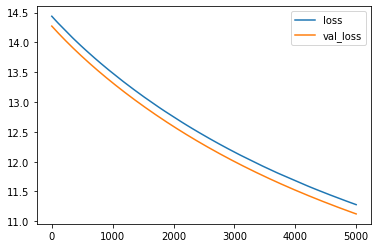

In [138]:
version = 1
history_file = 'data/history/history_{}.txt'.format(str(version))
dict_to_save = {}
for k, v in hist.history.items():
    dict_to_save.update({k: [np.format_float_positional(x) for x in hist.history[k]]})
with open(history_file, 'w') as file:
    json.dump(dict_to_save, file)
ep_max = epoch_num
plt.plot(hist.history['loss'][:ep_max], label='loss')
plt.plot(hist.history['val_loss'][:ep_max], label='val_loss')
plt.legend()
plt.show()
# plt.plot(hist.history['accuracy'][:ep_max], label='binary_accuracy')
# plt.plot(hist.history['val_accuracy'][:ep_max], label='val_binary_accuracy')
# plt.legend()
# plt.show()

## SUBMISSION 

In [139]:
sub_df = pd.read_csv('data/submission.csv')

In [140]:
tmp_sub = sub_df.copy()
sub_CARD_SIDO_NM_list = list(tmp_sub['CARD_SIDO_NM'].unique())
sub_STD_CLSS_NM_list =  list(tmp_sub['STD_CLSS_NM'].unique())

for i in range(len(sub_CARD_SIDO_NM_list)):
    tmp_city = sub_CARD_SIDO_NM_list[i]
    tmp_sub['CARD_SIDO_NM'].replace(tmp_city,i,inplace=True)

for i in range(len(sub_STD_CLSS_NM_list)):
    tmp_CLSS = sub_STD_CLSS_NM_list[i]
    tmp_sub['STD_CLSS_NM'].replace(tmp_CLSS,i,inplace=True)

In [141]:
tmp_sub

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,0,202004,0,0,0
1,1,202004,0,1,0
2,2,202004,0,2,0
3,3,202004,0,3,0
4,4,202004,0,4,0
...,...,...,...,...,...
1389,1389,202007,16,36,0
1390,1390,202007,16,37,0
1391,1391,202007,16,38,0
1392,1392,202007,16,39,0


In [142]:
test_X = tmp_sub[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM']]

In [143]:
test_Y = model.predict(test_X)

In [144]:
for i in test_Y:
    print(i)

[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[111

[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[11150.893]
[111